# Netflix Analysis

### First We import the necessary libraries for our work.

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

netflix_palette = {"black": '#221f1f',"dark red": '#b20710', "red": '#e50914',"white": '#f5f5f1'}

## We Built The "wrangle" function that takes the path to the dataset and import it in a pandas dataframe then:
## It performs some cleaning on the attributes of the data:
### - We find that the null value percentage is big so we filled it in the important attributes only instead of removing it<br>- filling the null values of the attributes of interest with "No Data" but for the 'rating' column did some searches to find the ratings of the films as the null in this column wasn't big compared to the other attributes<br> -  Dropping the inimportant attributes like ['show_id', 'description']
## Performing Feature extraxtion and Engineering on the attributes:
### - Converting the 'release_date' column into datetime <br> - Extracting various attributes from it Like "release_year", "release_month", "month", "day_name", "day_of_year", "day_of_month" <br> - Extracting the "num_duration" column from the duration attribute to make it numeric. <br> - assigning each rating its own target age and making the "target_ages" attribute from it. <br> - Encoding the "category" column ["Movie", "TV Show"] into "num_category"  [0, 1]

In [196]:
def wrangle(path):
    
    df = pd.read_csv(path)    
        
    df.columns = df.columns.str.lower()
    
    #df["country"]=df["country"].fillna(df["country"].mode()[0])
    df[['director', 'cast', 'country']] = df[['director', 'cast', 'country']].fillna("No Data")
    # Filling the null values in the rating column
    i = 0
    for f in df[df['rating'].isnull()]['title']:
        df.loc[df.title == f,'rating'] = ['TV-PG', 'TV-14', 'PG', 'TV-MA', 'TV-MA', 'TV-MA', 'PG-13'][i]
        i += 1
        
    df.dropna(inplace = True)
    df.drop_duplicates(inplace = True)
    
    df.drop(columns = ['show_id', 'description'], inplace=True)
    
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month_name() # for extract months name of the year
    df['month'] =df['release_date'].dt.month # for extract months of the year
    df['day_of_year'] = df['release_date'].dt.day_of_year # for extract day of the year
    df['day_of_month'] = df['release_date'].dt.days_in_month # for extract how many day in month
    df['day_name'] = df['release_date'].dt.day_name() # for day name
    
    # Encoding the duration column
    df['num_duration'] = df['duration'].str.split(" ").str[0]
    df['num_duration'] = pd.to_numeric(df['num_duration'])

    ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
    } 
    
    df['target_ages'] = df['rating'].replace(ratings_ages)  #replace the ratings with above category
    
    df["category_num"] = (df["category"] == "Movie").astype(int)
    
    return df

df = wrangle(r"E:\edu\Data Minning\Netflix Dataset.csv\Netflix Dataset.csv")

print("Number Of Null Values:\n",df.isnull().sum(),"\n","=" * 40)
print("Number of duplicated rows: ", df.duplicated().sum(),"\n","=" * 40)
df.head()

Number Of Null Values:
 category         0
title            0
director         0
cast             0
country          0
release_date     0
rating           0
duration         0
type             0
release_year     0
release_month    0
month            0
day_of_year      0
day_of_month     0
day_name         0
num_duration     0
target_ages      0
category_num     0
dtype: int64 
Number of duplicated rows:  0 


,category,title,director,cast,country,release_date,rating,duration,type,release_year,release_month,month,day_of_year,day_of_month,day_name,num_duration,target_ages,category_num
0,TV Show,3%,No Data,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",2020,August,8,227,31,Friday,4,Adults,0
1,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,TV-MA,93 min,"Dramas, International Movies",2016,December,12,358,31,Friday,93,Adults,1
2,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,R,78 min,"Horror Movies, International Movies",2018,December,12,354,31,Thursday,78,Adults,1
3,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...",2017,November,11,320,30,Thursday,80,Teens,1
4,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,PG-13,123 min,Dramas,2020,January,1,1,31,Wednesday,123,Teens,1


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7777 entries, 0 to 7788
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   category       7777 non-null   object        
 1   title          7777 non-null   object        
 2   director       7777 non-null   object        
 3   cast           7777 non-null   object        
 4   country        7777 non-null   object        
 5   release_date   7777 non-null   datetime64[ns]
 6   rating         7777 non-null   object        
 7   duration       7777 non-null   object        
 8   type           7777 non-null   object        
 9   release_year   7777 non-null   int64         
 10  release_month  7777 non-null   object        
 11  month          7777 non-null   int64         
 12  day_of_year    7777 non-null   int64         
 13  day_of_month   7777 non-null   int64         
 14  day_name       7777 non-null   object        
 15  num_duration   7777 n

## Data Analysis

## The mean Descriptive statistics of the data.

In [198]:
df.describe().style.background_gradient(cmap = 'coolwarm')

,release_year,month,day_of_year,day_of_month,num_duration,category_num
count,7777.000000,7777.000000,7777.000000,7777.000000,7777.000000,7777.000000
mean,2018.493378,6.783850,187.786807,30.513823,69.204706,0.691398
std,1.388144,3.591608,110.249247,0.737966,50.931983,0.461946
min,2008.000000,1.000000,1.000000,28.000000,1.000000,0.000000
25%,2018.000000,4.000000,91.000000,30.000000,2.000000,0.000000
50%,2019.000000,7.000000,193.000000,31.000000,88.000000,1.000000
75%,2020.000000,10.000000,285.000000,31.000000,106.000000,1.000000
max,2021.000000,12.000000,366.000000,31.000000,312.000000,1.000000


## Movies VS TV Shows Percentage

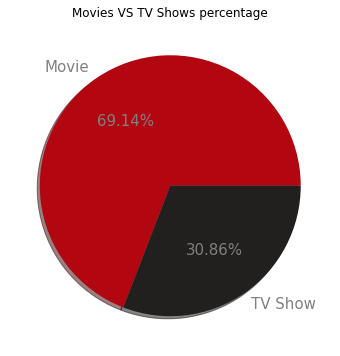

In [199]:
plt.figure(figsize = (12, 6))
cat_df = (df['category'].value_counts(normalize = True)).sort_values(ascending = False).to_frame()
plt.pie(cat_df['category'], labels = cat_df.index, colors = [netflix_palette['dark red'], netflix_palette['black']]
       ,autopct = '%0.2f%%',shadow = True, textprops={'color':"gray", "size": 15});
plt.title("Movies VS TV Shows percentage");

### The movies is the product that netflix focuses on in its work more than tv shows.

## Showing the most frequent ratings and ages targeted by netflix 

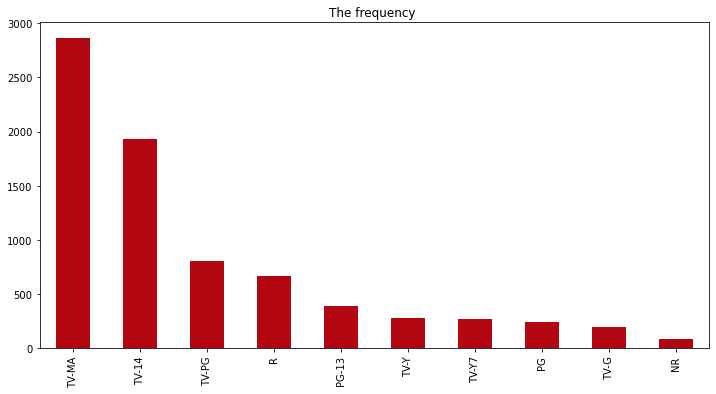

In [200]:
rating_counts = df['rating'].value_counts()
rating_counts.head(10).plot(kind = 'bar', color = netflix_palette['dark red'], title = "The frequency ", figsize = (12,6));

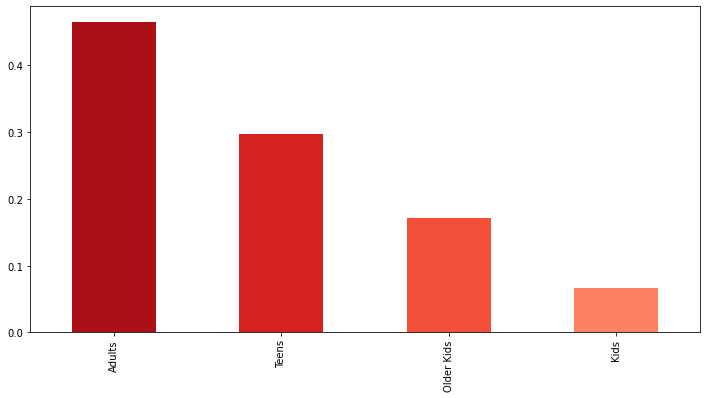

In [201]:
df["target_ages"].value_counts(normalize =True).plot(
    kind="bar",color = sns.color_palette('Reds_r'), figsize = (12,6)
);

### We conclude that Netflix focuses its work on the adult content more than the kids content.

## Map_count Func:
### -As we have some column with multvle attributes for the same row We made a function to extract the unique values of the column and mapping it to Its count.
### -It consists with two function "col_unique_count" it extracts the unique calues from the column <br> and "map_counts" that map the values to its counts.

In [202]:
def col_unique_count(col):
    
    unique_items = set()
    
    for c in df[col].str.split(","):
        if len(c) != 1:
            for i in c:
                unique_items.add(i.strip())
        else:
            unique_items.add(c[0].strip()) 
            
    unique_items = list(unique_items)
    
    return unique_items


def map_counts(col):
    
    unique_count_items = {}
    unique_col = col_unique_count(col)
    
    for uc in unique_col:
        if uc not in unique_count_items.keys():
            unique_count_items[uc] = len(df[df[col].str.contains(uc)])
            
    df_unique_count = pd.Series(unique_count_items.values(), index = unique_count_items.keys()).sort_values(ascending = False).to_frame()
    df_unique_count.columns = ["count"]
    df_unique_count = df_unique_count[(df_unique_count.index != "") & (df_unique_count.index != "Movies") & (df_unique_count.index != "TV Shows")]
    return df_unique_count


### We used the previous function to perform some analysis like showing the countries with the most work on Netflix.

In [203]:
unique_count_countries = map_counts('country')
unique_count_countries.head()

,count
United States,3291
India,990
United Kingdom,722
No Data,506
Canada,412


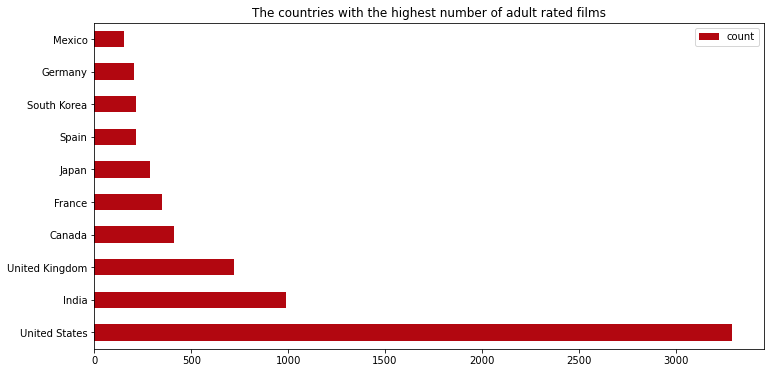

In [204]:
unique_count_countries[(unique_count_countries.index != "No Data") & (unique_count_countries.index != "")].head(10).plot(
    kind = "barh", color = netflix_palette['dark red'],
    title = "The countries with the highest number of adult rated films", figsize = (12,6));

### We can see that the country with the most content in movies and TV Shows is The USA by far, UK and India comes right after it.

# Top 10 director

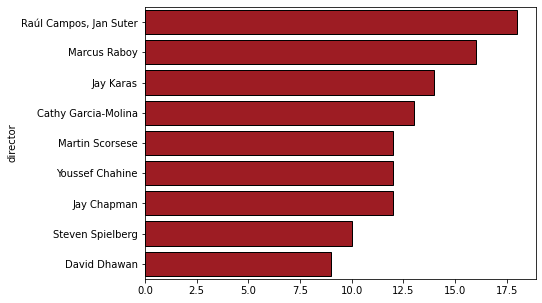

In [205]:
director = df['director'].value_counts().head(10)
x_values = director.values[1:]
y_values = director.index[1:]
plt.figure(figsize=(7,5))
sns.barplot(x = x_values,y = y_values,color = netflix_palette['dark red'],ec='black')
plt.ylabel("director");

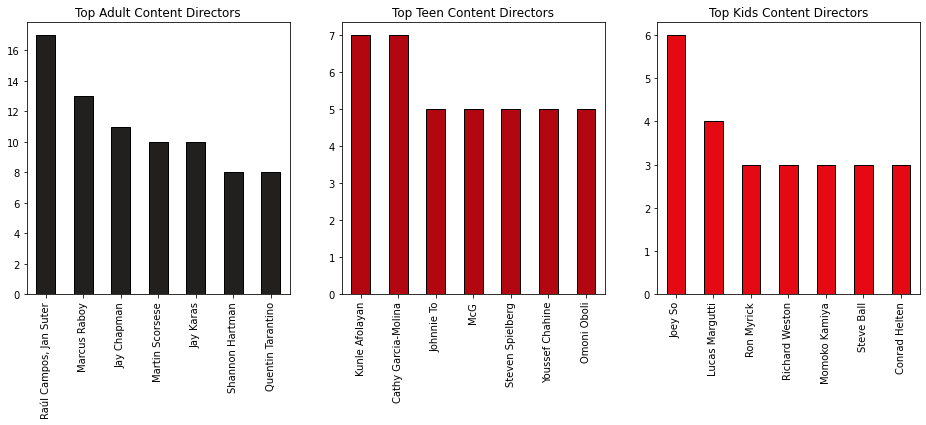

In [206]:
fig, ax = plt.subplots(1, 3, figsize = (16,5))
df[df['target_ages'] == "Adults"]['director'].value_counts()[1:8].plot.bar(color = netflix_palette['black'],ec='black', ax = ax[0]);
df[df['target_ages'] == "Teens"]['director'].value_counts()[1:8].plot.bar(color = netflix_palette['dark red'],ec='black', ax = ax[1]);
df[df['target_ages'] == "Kids"]['director'].value_counts()[1:8].plot.bar(color = netflix_palette['red'],ec='black', ax = ax[2]);

ax[0].set_title("Top Adult Content Directors");
ax[1].set_title("Top Teen Content Directors");
ax[2].set_title("Top Kids Content Directors");

# Release Year

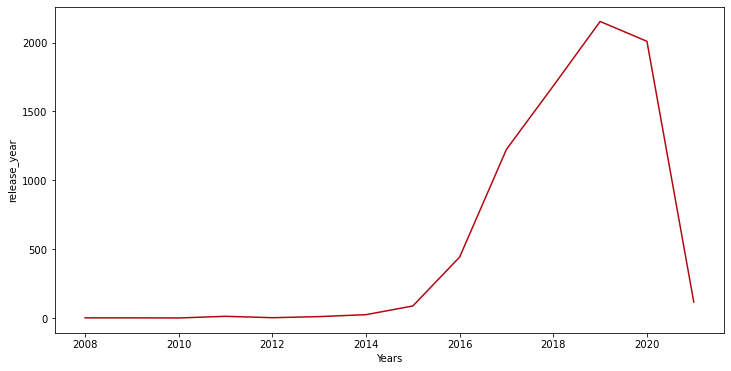

In [207]:
release_year = df['release_year'].value_counts()
x_values = release_year.values
plt.figure(figsize=(12,6))
sns.lineplot(data = release_year, color = netflix_palette['dark red'])
plt.xlabel("Years");

### Netflix has released most number of content around 2019 ever in the history of the Netflix.

## Release Quarters

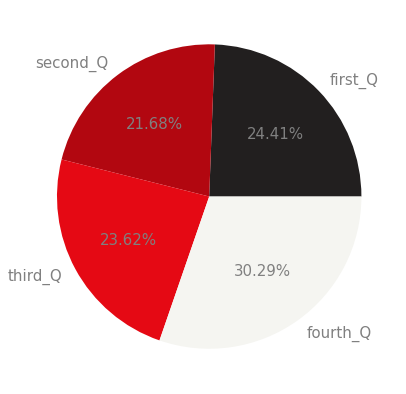

In [208]:
quarter_count = {
    'first_Q': len(df[df['month'].isin([1, 2, 3])]),
	'second_Q':len(df[df['month'].isin([4, 5, 6])]),
	'third_Q':len(df[df['month'].isin([7, 8, 9])]),
	'fourth_Q':len(df[df['month'].isin([10, 11, 12])]),
}

plt.figure(figsize = (15, 7))
plt.pie(quarter_count.values(), labels = quarter_count.keys(), colors = netflix_palette.values(),autopct = '%0.2f%%', textprops={'color':"gray", "size": 15});

### We Can see thet the quarter with the most releases for netflix is the fourth quarter and the one with the least releases is the second quarter.

# Top 5 types

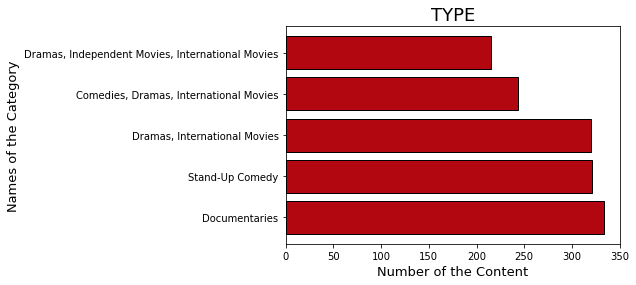

In [209]:
x = list(df['type'].value_counts().head().keys())
y = list(df['type'].value_counts().head())
plt.barh(x,y,color = netflix_palette['dark red'],ec='black')
plt.title("TYPE",fontsize=18)
plt.xlabel("Number of the Content",fontsize=13)
plt.ylabel('Names of the Category',fontsize=13)
plt.show()

### The combination Categories of the most of the content produces by Netflix are Documentaries, Stand-Up Comedy and Dramas, International Movies. 

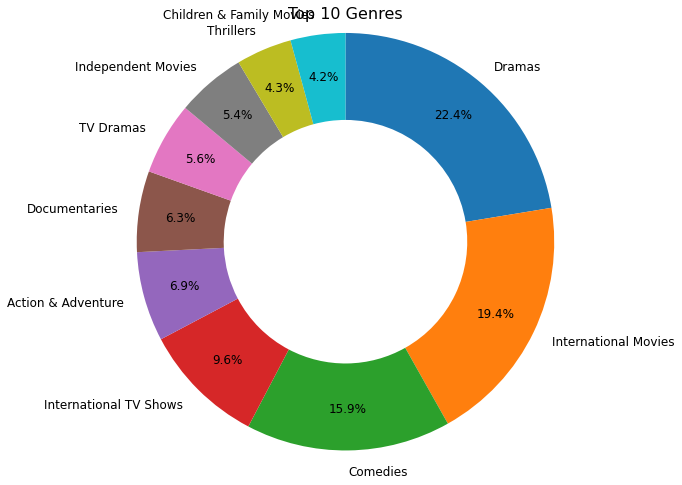

In [210]:
top_genres = map_counts('type').head(10)
plt.figure(figsize=(8,8))
plt.pie(top_genres['count'], labels=top_genres.index, autopct='%1.1f%%', pctdistance = 0.8, labeldistance=1.1, 
        radius=1.2, wedgeprops=dict(width=0.5), startangle=90, 
        textprops = dict(color="black", fontsize=12), counterclock=False)
plt.title('Top 10 Genres', fontsize=16)
plt.show()

### The unique categories with the most work on Netflix is: Dramas, International Movies and Comedies

# Top 10 countries producing Movies on Netflix

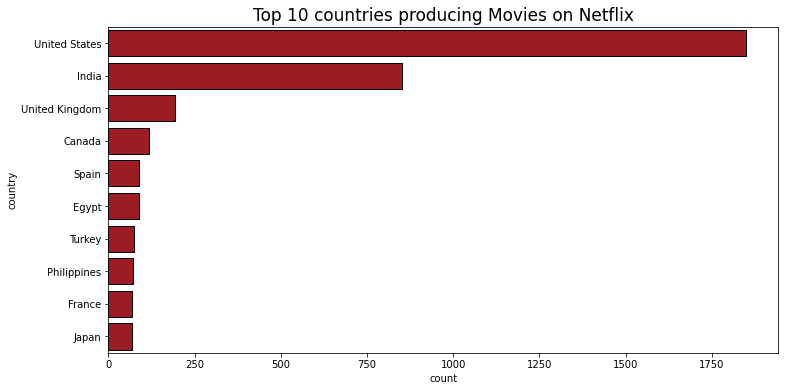

In [211]:
movie_countries=df[(df['category']=='Movie') & (df['country'] != "No Data")]

plt.figure(figsize=(12,6))
sns.countplot(y='country',order=movie_countries['country'].value_counts().index[0:10],
              data=movie_countries,ec='black',color=netflix_palette['dark red'])
plt.title('Top 10 countries producing Movies on Netflix',fontsize=17);

### United States produces most number of Movies on the Netflix, followed by India.

# Top 10 countries producing TV Show on Netflix

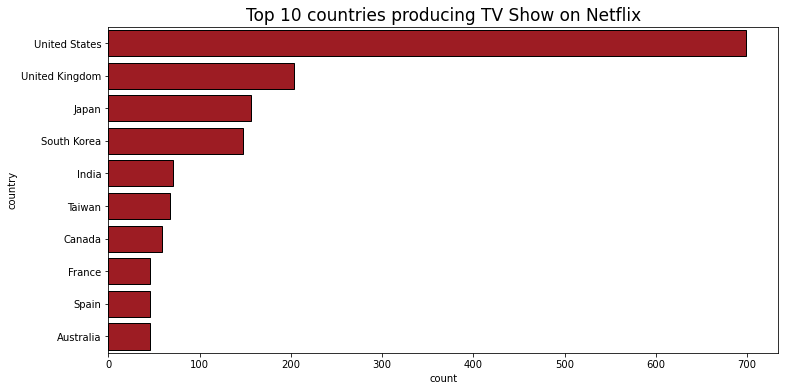

In [212]:
movie_countries=df[(df['category']=='TV Show') & (df['country'] != "No Data")]

plt.figure(figsize=(12,6))
sns.countplot(y='country',order=movie_countries['country'].value_counts().index[0:10],
              data=movie_countries,ec='black',color=netflix_palette['dark red'])
plt.title('Top 10 countries producing TV Show on Netflix',fontsize=17);

### United States produces most number of TV Shows on the Netflix, followed by United Kingdom 

### Machine Learning Model

### Our Model Predicts The rating of the Movie Or TV Show based on the Other Features.
### - As Our Feature matrix has some String Variables in it We used OrdinalEncoder to encode it .
### - along with the DecisionTree Classifier to classify the work of Netflix.
### Using the Pipeline to Integrate those Tools together.

In [213]:
X = df.drop(columns = ['rating', 'release_year', 'release_date', 'category', 'duration', 'cast'])
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6221, 12)
y_train shape: (6221,)
X_test shape: (1556, 12)
y_test shape: (1556,)


In [214]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier()
)
model_rf.fit(X_train, y_train)
acc1 = model_rf.score(X_train, y_train)
acc2 = model_rf.score(X_test, y_test)
print("Random Forest Classifier Test Success Rate is :", "{:.2f}%".format(100*acc1))
print("Random Forest Classifier Test Success Rate is :", "{:.2f}%".format(100*acc2))

Random Forest Classifier Test Success Rate is : 100.00%
Random Forest Classifier Test Success Rate is : 81.49%


In [216]:
precision_train = precision_score(y_train, model_rf.predict(X_train), average='weighted')
precision_test = precision_score(y_test, model_rf.predict(X_test), average='weighted')
recall_train = recall_score(y_train, model_rf.predict(X_train), average='weighted')
recall_test = recall_score(y_test, model_rf.predict(X_test), average='weighted')
f1_train = f1_score(y_train, model_rf.predict(X_train), average='weighted')
f1_test = f1_score(y_test, model_rf.predict(X_test), average='weighted')

print("Training Accuracy Scores:", model_rf.score(X_train,y_train) * 100, "%")
print("Test Accuracy Scores:", model_rf.score(X_test,y_test) * 100, "%")
print("Precision_train:", precision_train * 100, "%")
print("Precision_test:", precision_test * 100, "%")
print("Recall_train:", recall_train * 100, "%")
print("Recall_test:", recall_test * 100, "%")
print("F1-score_train:", f1_train * 100, "%")
print("F1-score_test:", f1_test * 100, "%")

Training Accuracy Scores: 100.0 %
Test Accuracy Scores: 81.49100257069408 %
Precision_train: 100.0 %
Precision_test: 79.8433772861932 %
Recall_train: 100.0 %
Recall_test: 81.49100257069408 %
F1-score_train: 100.0 %
F1-score_test: 77.9594059315577 %
